## Pattern Recognition and Machine Learning Project

### Importing necessary libraries

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import pandas as pd
import random
import shutil
from PIL import Image
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from cvxopt import matrix, solvers
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### Data directories

In [3]:
# Define directories
base_dir = os.path.join('..', '..','data', 'illinois_doc_dataset')
front_dir = os.path.join(base_dir, "front/front")
side_dir = os.path.join(base_dir, "side/side")
output_dir = "extracted_features"  # Directory to save features
os.makedirs(output_dir, exist_ok=True)
front_src_folder = front_dir
side_src_folder = side_dir
front_dest_folder = 'sel_front/'
side_dest_folder = 'sel_side/'


### Face Detection using MTCNN detector

In [4]:
# Initialize MTCNN detector
mtcnn_detector = MTCNN()

def detect_faces_mtcnn(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = mtcnn_detector.detect_faces(img_rgb)
    
    # If faces detected, crop the first face; otherwise, use the full image
    if len(detections) > 0:
        x, y, w, h = detections[0]['box']
        face = img[y:y+h, x:x+w]
    else:
        face = img
    return face

def detected_face_display(img):
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for MTCNN
    detections = mtcnn_detector.detect_faces(img_rgb)
    
    for detection in detections:
        x, y, w, h = detection['box']
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()


### Feature Extraction using VGG16 model

#### Cleaning and analysing person.csv

Loading Person dataset

In [5]:
# Load the dataset
person_path= os.path.join(base_dir, 'csv','person.csv')
person=pd.read_csv(person_path,sep=';')
person.head()   

id              name date_of_birth  weight                    hair  \
0  A00147  MCCUTCHEON, JOHN    06/14/1949   185.0                   Brown   
1  A00220     WALKER, ISIAH    03/30/1957   155.0                   Black   
2  A00360      BELL, HOWARD    12/18/1946   167.0  Gray or Partially Gray   
3  A00367   GARVIN, RAYMOND    01/12/1954   245.0                   Black   
4  A01054   TIPTON, DARNELL    03/25/1954   166.0         Salt and Pepper   

    sex  height   race   eyes admission_date  ... projected_discharge_date  \
0  Male    67.0  White   Blue     02/16/1983  ...               10/06/2036   
1  Male    73.0  Black  Brown     05/19/2016  ...                      NaN   
2  Male    69.0  White  Green     02/26/1988  ...         TO BE DETERMINED   
3  Male    72.0  Black  Brown     11/09/2017  ...               11/20/2020   
4  Male    67.0  Black  Brown     12/23/1988  ...               08/14/2068   

  parole_date electronic_detention_date discharge_date  \
0         NaN                       NaN            NaN   
1         NaN                       NaN            NaN   
2  10/02/2017                       NaN            NaN   
3         NaN                       NaN            NaN   
4         NaN                       NaN            NaN   

                     parent_institution   offender_status  \
0             DIXON CORRECTIONAL CENTER        IN CUSTODY   
1        STATEVILLE CORRECTIONAL CENTER  NON-IDOC CUSTODY   
2     PINCKNEYVILLE CORRECTIONAL CENTER            PAROLE   
3  WESTERN ILLINOIS CORRECTIONAL CENTER        IN CUSTODY   
4            MENARD CORRECTIONAL CENTER        IN CUSTODY   

                    location sex_offender_registry_required  \
0                      DIXON                           True   
1  ILL/OTH STATE/FED CONCURR                            NaN   
2          PAROLE DISTRICT 1                            NaN   
3           WESTERN ILLINOIS                            NaN   
4                     MENARD                           True   

                                               alias Unnamed: 21  
0                                                NaN         NaN  
1                                                NaN         NaN  
2  HOWARD R BELL | DONALD  BROADSTONE | RONALD  B...         NaN  
3                                                NaN         NaN  
4                                                NaN         NaN  

[5 rows x 22 columns]

Cleaning dataset

In [6]:
# Remove unwanted columns
unwanted=['name','hair','race','eyes','admission_date','projected_discharge_date', 'parole_date','electronic_detention_date','discharge_date','projected_parole_date','last_paroled_date','parent_institution','offender_status','location','sex_offender_registry_required','alias','Unnamed: 21']
person=person.drop(columns=unwanted)
print(person.head())
print(person.shape)

#  Drop rows with missing values
person=person.dropna()
person

       id date_of_birth  weight   sex  height
0  A00147    06/14/1949   185.0  Male    67.0
1  A00220    03/30/1957   155.0  Male    73.0
2  A00360    12/18/1946   167.0  Male    69.0
3  A00367    01/12/1954   245.0  Male    72.0
4  A01054    03/25/1954   166.0  Male    67.0
(61110, 5)


id date_of_birth  weight     sex  height
0      A00147    06/14/1949   185.0    Male    67.0
1      A00220    03/30/1957   155.0    Male    73.0
2      A00360    12/18/1946   167.0    Male    69.0
3      A00367    01/12/1954   245.0    Male    72.0
4      A01054    03/25/1954   166.0    Male    67.0
...       ...           ...     ...     ...     ...
61104  Y25362    05/30/1985   120.0    Male    59.0
61105  Y25363    05/15/1986   170.0    Male    71.0
61106  Y25364    02/23/1972   112.0  Female    62.0
61107  Y25365    06/16/1992   158.0  Female    63.0
61108  Y25366    03/04/1949   220.0    Male    67.0

[60713 rows x 5 columns]

Adding BMI index and corresponding labels

In [7]:
# Converting height to meters and weight to kg
person['height'] = person['height'] * 2.54 / 100
person['weight'] = person['weight'] * 0.453592

# Calculating bmi 
person['bmi']=person['weight']/(person['height'])**2
print(person.head())

def find_label(bmi):
    if bmi<18.5:
        return 'Underweight'
    elif bmi>=18.5 and bmi <24.9:
        return 'Normal'
    elif bmi>=25 and bmi<29.9:
        return 'Overweight'
    else:
        return 'Obese'
    
person['bmi_label']=person['bmi'].apply(find_label)
person.head()

       id date_of_birth      weight   sex  height        bmi
0  A00147    06/14/1949   83.914520  Male  1.7018  28.974775
1  A00220    03/30/1957   70.306760  Male  1.8542  20.449558
2  A00360    12/18/1946   75.749864  Male  1.7526  24.661316
3  A00367    01/12/1954  111.130040  Male  1.8288  33.227605
4  A01054    03/25/1954   75.296272  Male  1.7018  25.998988


id date_of_birth      weight   sex  height        bmi   bmi_label
0  A00147    06/14/1949   83.914520  Male  1.7018  28.974775  Overweight
1  A00220    03/30/1957   70.306760  Male  1.8542  20.449558      Normal
2  A00360    12/18/1946   75.749864  Male  1.7526  24.661316      Normal
3  A00367    01/12/1954  111.130040  Male  1.8288  33.227605       Obese
4  A01054    03/25/1954   75.296272  Male  1.7018  25.998988  Overweight

Composition of Gender

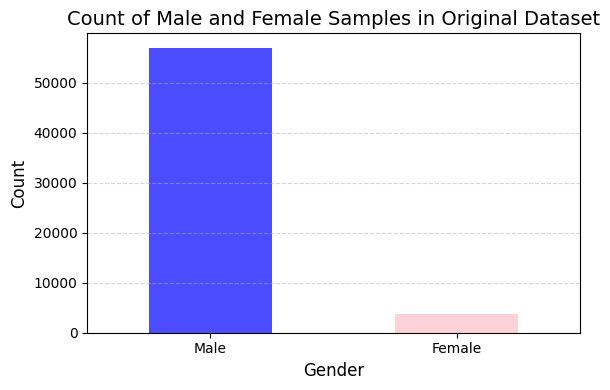

In [8]:
gender_counts = person['sex'].value_counts()

plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)

# Adding labels and title
plt.title("Count of Male and Female Samples in Original Dataset", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [9]:
# Getting male ids
male_id=person[person['sex']=='Male']['id'].tolist()
print('Number of males(after preprocessing):',len(male_id))

Number of males(after preprocessing): 56982


In [10]:
# Getting female ids
female_id=person[person['sex']=='Female']['id'].tolist()
print('Number of females(after preprocessing):',len(female_id))

Number of females(after preprocessing): 3731


#### Random Sample chosen

Populating the sample with valid images of Males and Females

In [ ]:
# Function to validate an image
def is_valid_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()  # Check if the image can be opened
        return True
    except (IOError, SyntaxError):
        return False

# Function to get valid paired images (front and side)
def get_valid_pairs(image_list, front_folder, side_folder, target_count):
    valid_pairs = []
    processed_images = set()

    for img in image_list:
        if len(valid_pairs) == target_count:
            break

        if img in processed_images:
            continue

        front_path = os.path.join(front_folder, img)
        side_path = os.path.join(side_folder, img)

        if (
            os.path.exists(front_path) and is_valid_image(front_path) and
            os.path.exists(side_path) and is_valid_image(side_path)
        ):
            valid_pairs.append(img)
            processed_images.add(img)

    return valid_pairs

# Prepare male and female image lists
male_img = [f"{id}.jpg" for id in male_id]
female_img = [f"{id}.jpg" for id in female_id]

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Shuffle the datasets
random.shuffle(male_img)
random.shuffle(female_img)

# Define folders
front_src_folder = front_dir
side_src_folder = side_dir
front_dest_folder = 'sel_front/'
side_dest_folder = 'sel_side/'

os.makedirs(front_dest_folder, exist_ok=True)
os.makedirs(side_dest_folder, exist_ok=True)

# Get 3000 valid male pairs and 3000 valid female pairs
male_pairs = get_valid_pairs(male_img, front_src_folder, side_src_folder, 3000)
female_pairs = get_valid_pairs(female_img, front_src_folder, side_src_folder, 3000)

# Copy the valid male and female pairs to destination folders
def copy_pairs(pairs, front_src, side_src, front_dest, side_dest, gender):
    for img in pairs:
        shutil.copy(os.path.join(front_src, img), os.path.join(front_dest, img))
        shutil.copy(os.path.join(side_src, img), os.path.join(side_dest, img))
    print(f"{gender}: {len(pairs)} valid front-side pairs copied.")

# Copy valid pairs for males and females
copy_pairs(male_pairs, front_src_folder, side_src_folder, front_dest_folder, side_dest_folder, "Male")
copy_pairs(female_pairs, front_src_folder, side_src_folder, front_dest_folder, side_dest_folder, "Female")


### Display images

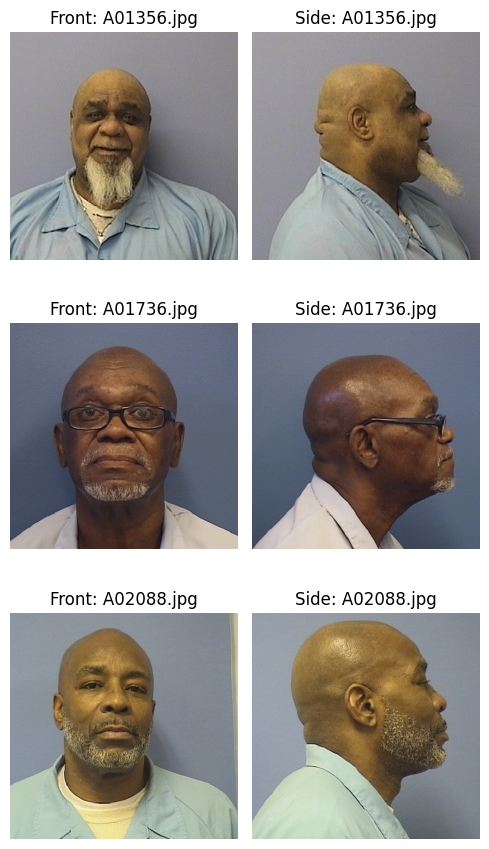

In [11]:
def display_images(front_folder, side_folder, sample_count=3):
    # Get list of images in both folders
    front_images = [os.path.join(front_folder, f) for f in os.listdir(front_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    side_images = [os.path.join(side_folder, f) for f in os.listdir(side_folder) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # Sort to align pairs if possible
    front_images.sort()
    side_images.sort()
    
    # Determine the number of samples to display
    display_count = min(sample_count, len(front_images), len(side_images))
    
    # Plot images side by side
    fig, axes = plt.subplots(display_count, 2, figsize=(5, 3 * display_count))
    for i in range(display_count):
        # Load front image
        front_img = cv2.imread(front_images[i])
        front_img = cv2.cvtColor(front_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
        
        # Load side image
        side_img = cv2.imread(side_images[i])
        side_img = cv2.cvtColor(side_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib
        
        # Display front image
        axes[i, 0].imshow(front_img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Front: {os.path.basename(front_images[i])}", fontsize=12)
        
        # Display side image
        axes[i, 1].imshow(side_img)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Side: {os.path.basename(side_images[i])}", fontsize=12)
    
    plt.tight_layout()
    plt.show()

front_folder='sel_front/'
side_folder='sel_side/'
display_images(front_folder, side_folder, sample_count=3)


#### VGG16 Model

In [12]:
# Load pre-trained VGG16 model
base_model = VGG16(weights="imagenet")
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def preprocess_image(image, target_size=(224, 224)):
    """Resize and preprocess image for VGG16."""
    img_resized = cv2.resize(image, target_size)
    img_array = img_to_array(img_resized)
    return preprocess_input(np.expand_dims(img_array, axis=0))

def extract_features(image_path):
    """Extract features using VGG16."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Skipping {image_path} (image not found or invalid).")
        return None
    cropped_image = detect_faces_mtcnn(image)
    processed_image = preprocess_image(cropped_image)
    features = model.predict(processed_image).flatten()
    return features

#### Extracting features

Using the Pre-trained VGG16 and store them 

In [12]:
# Process images in sel_front and sel_side folders
results = []

count=0
for folder, folder_name in [(front_dest_folder, 'front'), (side_dest_folder, 'side')]:
    print(f"Processing folder: {folder_name}")
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        features = extract_features(img_path)
        if features is not None:
            results.append({
                "image": img_name,
                "folder": folder_name,
                "features": features
            })
            print(f"{count} Processed image: {img_name}")
            count+=1


Processing folder: front
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
0 Processed image: A01356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1 Processed image: A01736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
2 Processed image: A02088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
3 Processed image: A10002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
4 Processed image: A10133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
5 Processed image: A10508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
6 Processed image: A15324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
7 Processed image: A15856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
8 Processed image: A26050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
9 Processed image: A50207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
10 Processed image: A50321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
11 Processed image: A60810.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
12 Processed image: A61492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
13 Processed image: A62475.jpg
1/1 ━

In [13]:

print(f"Total number of images processed: {len(results)}")

Total number of images processed: 12000


List of layers of the model

In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

Expanding features obtained from array-like to columns with individual values

In [15]:
# convert results in df
df_results=pd.DataFrame(results)
print(df_results.head())
print(df_results.shape)
print(df_results['features'][0].size)


        image folder                                           features
0  A01356.jpg  front  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.042...
1  A01736.jpg  front  [0.0, 0.24394809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...
2  A02088.jpg  front  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.242...
3  A10002.jpg  front  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.151...
4  A10133.jpg  front  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.362...
(12000, 3)
4096


In [16]:
# Use NumPy for efficient expansion
features_array = np.vstack(df_results['features'].values)

# Create column names dynamically
column_names = [f"f{i}" for i in range(features_array.shape[1])]

# Create a DataFrame from the NumPy array
features_expanded = pd.DataFrame(features_array, columns=column_names, index=df_results.index)

# Concatenate back with the original DataFrame
features_df = pd.concat([df_results.drop(columns=['features']), features_expanded], axis=1)


In [17]:
# Display the first few rows of the transformed DataFrame
print(features_df.head())
print(features_df.shape)

        image folder   f0        f1   f2   f3   f4   f5   f6   f7  ...  f4086  \
0  A01356.jpg  front  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
1  A01736.jpg  front  0.0  0.243948  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
2  A02088.jpg  front  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
3  A10002.jpg  front  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   
4  A10133.jpg  front  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0   

      f4087  f4088     f4089     f4090     f4091  f4092  f4093     f4094  \
0  0.000000    0.0  0.000000  0.000000  1.012925    0.0    0.0  1.442925   
1  0.000000    0.0  0.161015  0.915044  1.121552    0.0    0.0  0.000000   
2  0.000000    0.0  0.000000  0.000000  1.541219    0.0    0.0  0.000000   
3  0.000000    0.0  0.000000  0.122375  0.123428    0.0    0.0  0.000000   
4  1.512895    0.0  0.000000  0.000000  1.742094    0.0    0.0  0.000000   

      f4095  
0  0.000000  
1  0.357244  
2  0.000000  


Saving the features to csv files (checkpoint)

In [18]:
# Save features to features.csv
features_df.to_csv(os.path.join(output_dir, "extracted_features.csv"), index=False)
print(f"Features saved to: {output_dir}/extracted_features.csv")

Features saved to: extracted_features/extracted_features.csv


Merging corresponding front and side features

In [19]:
# Forming a DataFrame with both front and side features
extracted_df=pd.read_csv(os.path.join(output_dir, "extracted_features.csv"))

extracted_df.rename(columns={'image':'id'},inplace=True)
extracted_df['id']=extracted_df['id'].apply(lambda x: x.split('.')[0])

front_df=extracted_df[extracted_df['folder']=='front'].copy()
front_df=front_df.drop(columns='folder')

side_df=extracted_df[extracted_df['folder']=='side'].copy()
side_df=side_df.drop(columns='folder')
side_df.columns = ['id'] + [f's{i}' for i in range(len(side_df.columns) - 1)]

merged_df=pd.merge(front_df,side_df,on='id',how='inner')
merged_df.to_csv(os.path.join(output_dir, "merged_features.csv"), index=False)
merged_df

id   f0        f1   f2   f3   f4   f5   f6        f7        f8  ...  \
0     A01356  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.042265  ...   
1     A01736  0.0  0.243948  0.0  0.0  0.0  0.0  0.0  0.000000  2.353524  ...   
2     A02088  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.242251  ...   
3     A10002  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.151707  ...   
4     A10133  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.362024  ...   
...      ...  ...       ...  ...  ...  ...  ...  ...       ...       ...  ...   
5995  Y25331  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.225534  ...   
5996  Y25340  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.114581  4.972428  ...   
5997  Y25361  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.288807  3.091961  ...   
5998  Y25364  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.572976  ...   
5999  Y25365  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.992458  ...   

      s4086     s4087     s4088     s4089     s4090     s4091     s4092  \
0       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.0  0.000000  0.000000  0.000000  0.000000  1.075095  0.000000   
2       0.0  0.000000  0.000000  0.000000  0.497550  0.000000  0.000000   
3       0.0  0.000000  0.128862  0.000000  1.122430  0.000000  0.000000   
4       0.0  0.000000  0.000000  1.063854  2.163577  1.643237  0.000000   
...     ...       ...       ...       ...       ...       ...       ...   
5995    0.0  0.108074  0.000000  1.111613  0.000000  2.519527  0.000000   
5996    0.0  0.000000  0.000000  0.000000  0.000000  1.965373  0.241738   
5997    0.0  0.000000  0.000000  0.000000  0.000000  0.254477  0.000000   
5998    0.0  0.232008  0.000000  0.746731  0.373246  1.970375  0.000000   
5999    0.0  0.000000  0.000000  0.000000  0.000000  0.932318  0.000000   

         s4093     s4094     s4095  
0     0.000000  0.517922  1.389551  
1     0.000000  0.000000  0.000000  
2     0.300171  0.222557  0.000000  
3     0.000000  0.620006  2.040654  
4     1.562122  1.040361  0.000000  
...        ...       ...       ...  
5995  1.202890  0.000000  0.000000  
5996  1.111914  0.000000  0.000000  
5997  0.000000  0.000000  1.238373  
5998  0.000000  0.000000  2.058303  
5999  0.000000  0.000000  0.000000  

[6000 rows x 8193 columns]

### Performing PCA on the feature set

In [13]:
merged_df=pd.read_csv(os.path.join(output_dir, "merged_features.csv"))

Checking for any erroneous rows

In [14]:
# Rows with all zero values
rows_all_zero = merged_df[(merged_df == 0).all(axis=1)]
rows_all_zero

Empty DataFrame
Columns: [id, f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16, f17, f18, f19, f20, f21, f22, f23, f24, f25, f26, f27, f28, f29, f30, f31, f32, f33, f34, f35, f36, f37, f38, f39, f40, f41, f42, f43, f44, f45, f46, f47, f48, f49, f50, f51, f52, f53, f54, f55, f56, f57, f58, f59, f60, f61, f62, f63, f64, f65, f66, f67, f68, f69, f70, f71, f72, f73, f74, f75, f76, f77, f78, f79, f80, f81, f82, f83, f84, f85, f86, f87, f88, f89, f90, f91, f92, f93, f94, f95, f96, f97, f98, ...]
Index: []

[0 rows x 8193 columns]

Dropping empty feature columns

In [15]:
# Columns with all zero values
cols_all_zero = merged_df.loc[:, (merged_df == 0).all(axis=0)]
cols_all_zero

f22  f114  f133  f220  f235  f307  f375  f391  f412  f620  ...  s2310  \
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
5995  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5996  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5997  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5998  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   
5999  0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    0.0   

      s2393  s2801  s2823  s3030  s3332  s3457  s3592  s3883  s4059  
0       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
1       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
4       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
...     ...    ...    ...    ...    ...    ...    ...    ...    ...  
5995    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5996    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5997    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5998    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
5999    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[6000 rows x 119 columns]

In [16]:
# Dropping the columns with all zero values
final_df=merged_df.drop(columns=cols_all_zero)
final_df_copy=final_df.copy() # in case we need to revert back
final_df

id   f0        f1   f2   f3   f4   f5   f6        f7        f8  ...  \
0     A01356  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.042265  ...   
1     A01736  0.0  0.243948  0.0  0.0  0.0  0.0  0.0  0.000000  2.353524  ...   
2     A02088  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.242251  ...   
3     A10002  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.151707  ...   
4     A10133  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.362024  ...   
...      ...  ...       ...  ...  ...  ...  ...  ...       ...       ...  ...   
5995  Y25331  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  5.225534  ...   
5996  Y25340  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.114581  4.972428  ...   
5997  Y25361  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.288807  3.091961  ...   
5998  Y25364  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.572976  ...   
5999  Y25365  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.000000  3.992458  ...   

      s4086     s4087     s4088     s4089     s4090     s4091     s4092  \
0       0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.0  0.000000  0.000000  0.000000  0.000000  1.075095  0.000000   
2       0.0  0.000000  0.000000  0.000000  0.497550  0.000000  0.000000   
3       0.0  0.000000  0.128862  0.000000  1.122430  0.000000  0.000000   
4       0.0  0.000000  0.000000  1.063854  2.163577  1.643237  0.000000   
...     ...       ...       ...       ...       ...       ...       ...   
5995    0.0  0.108074  0.000000  1.111613  0.000000  2.519527  0.000000   
5996    0.0  0.000000  0.000000  0.000000  0.000000  1.965373  0.241738   
5997    0.0  0.000000  0.000000  0.000000  0.000000  0.254477  0.000000   
5998    0.0  0.232008  0.000000  0.746731  0.373246  1.970375  0.000000   
5999    0.0  0.000000  0.000000  0.000000  0.000000  0.932318  0.000000   

         s4093     s4094     s4095  
0     0.000000  0.517922  1.389551  
1     0.000000  0.000000  0.000000  
2     0.300171  0.222557  0.000000  
3     0.000000  0.620006  2.040654  
4     1.562122  1.040361  0.000000  
...        ...       ...       ...  
5995  1.202890  0.000000  0.000000  
5996  1.111914  0.000000  0.000000  
5997  0.000000  0.000000  1.238373  
5998  0.000000  0.000000  2.058303  
5999  0.000000  0.000000  0.000000  

[6000 rows x 8074 columns]

Removing columns which have high proportion of zeroes

In [17]:
t=0.80
zero_proportion=(final_df==0).sum(axis=0)/len(final_df)
print(zero_proportion)
cols_drop=zero_proportion[zero_proportion>t].index
print(cols_drop)
final_df=final_df.drop(columns=cols_drop)
final_df

id       0.000000
f0       0.995500
f1       0.999000
f2       0.999833
f3       0.952167
           ...   
s4091    0.094500
s4092    0.845500
s4093    0.786000
s4094    0.744500
s4095    0.492000
Length: 8074, dtype: float64
Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f9', 'f11',
       ...
       's4070', 's4072', 's4073', 's4076', 's4084', 's4086', 's4087', 's4088',
       's4089', 's4092'],
      dtype='object', length=4090)


id        f8       f10       f13       f16       f19       f20  \
0     A01356  5.042265  2.691381  2.499486  0.676433  2.291785  2.665528   
1     A01736  2.353524  0.000000  1.193248  3.385399  0.000000  0.785917   
2     A02088  5.242251  0.000000  0.033124  3.192647  0.000000  1.702981   
3     A10002  5.151707  1.355624  0.421916  1.910052  0.501849  0.964919   
4     A10133  3.362024  0.000000  0.678431  1.027946  0.000000  2.879604   
...      ...       ...       ...       ...       ...       ...       ...   
5995  Y25331  5.225534  1.958914  2.636910  0.175287  0.000000  1.271981   
5996  Y25340  4.972428  4.785717  0.566010  1.852343  0.000000  0.891258   
5997  Y25361  3.091961  4.171806  1.189704  0.000000  3.176173  1.425048   
5998  Y25364  3.572976  0.000000  1.096744  1.439884  0.584022  0.000000   
5999  Y25365  3.992458  0.000000  1.011830  1.602248  0.000000  0.381770   

           f21       f24       f26  ...     s4080     s4081     s4082  \
0     2.341313  0.000000  0.359262  ...  0.000000  1.524261  0.000000   
1     1.667873  0.000000  3.305284  ...  0.000000  2.067759  0.000000   
2     4.351820  0.000000  2.304736  ...  0.000000  0.901364  0.000000   
3     1.581095  0.000000  0.940719  ...  0.000000  0.000000  0.000000   
4     2.572125  0.000000  2.776913  ...  0.323639  0.762997  0.000000   
...        ...       ...       ...  ...       ...       ...       ...   
5995  3.874194  0.000000  1.654392  ...  0.386904  3.059034  1.137069   
5996  4.129135  3.441573  0.617646  ...  1.883763  4.756309  0.000000   
5997  1.489373  0.000000  0.000000  ...  0.000000  0.911641  0.000000   
5998  4.078278  0.000000  0.000000  ...  0.000000  0.743275  0.000000   
5999  3.074543  0.000000  0.991310  ...  1.017159  1.382056  0.170945   

         s4083     s4085     s4090     s4091     s4093     s4094     s4095  
0     2.316501  1.601866  0.000000  0.000000  0.000000  0.517922  1.389551  
1     1.767915  0.355863  0.000000  1.075095  0.000000  0.000000  0.000000  
2     2.500766  1.688079  0.497550  0.000000  0.300171  0.222557  0.000000  
3     0.606970  0.000000  1.122430  0.000000  0.000000  0.620006  2.040654  
4     2.853921  0.583110  2.163577  1.643237  1.562122  1.040361  0.000000  
...        ...       ...       ...       ...       ...       ...       ...  
5995  2.323330  0.000000  0.000000  2.519527  1.202890  0.000000  0.000000  
5996  2.108142  0.000000  0.000000  1.965373  1.111914  0.000000  0.000000  
5997  2.562352  0.000000  0.000000  0.254477  0.000000  0.000000  1.238373  
5998  3.314432  0.000000  0.373246  1.970375  0.000000  0.000000  2.058303  
5999  1.136673  0.000000  0.000000  0.932318  0.000000  0.000000  0.000000  

[6000 rows x 3984 columns]

Performing reduction of dimensions using PCA with a given confidence 

In [18]:
def pca(data,threshold=0.95):
    #step 1 : calculate mean vector
    mean=np.mean(data,axis=0)
    print("Mean vector shape:", mean.shape)

    #step 2: calculate covariance matrix
    n=len(data)
    z=np.zeros_like(data)
    for row in range(n):
        z[row]=data[row]-mean
    cov=(1/(n-1))*np.dot(np.transpose(z),z)
    print("Covariance matrix shape:",cov.shape)

    #step 3: Calculate eigen values and eigen vectors
    eigen_values,eigen_vectors=np.linalg.eigh(cov)

    #step 4: Sort them in descending order
    sorted_indices = np.argsort(eigen_values)[::-1]
    eigen_values = eigen_values[sorted_indices]
    eigen_vectors = eigen_vectors[:, sorted_indices]

    #step 5: Finding k
    var_ratio=eigen_values/np.sum(eigen_values)
    cum_var=np.cumsum(var_ratio)
    k=np.argmax(cum_var >= threshold) +1
    top_eigenvalues=eigen_values[:k]
    top_eigenvectors=eigen_vectors[:,:k]

    #step 6: project the data 
    reduced_data=np.dot(data,top_eigenvectors)
    return reduced_data,top_eigenvectors


Removing the id column for processing 

In [19]:
features=final_df.iloc[:,1:].to_numpy()
print(features.shape)

(6000, 3983)


PCA

In [20]:
reduced_features,eigen_vecs=pca(features,0.90)
print(reduced_features.shape)

Mean vector shape: (3983,)
Covariance matrix shape: (3983, 3983)
(6000, 353)


Adding relevant data to the reduced feature matrix

In [21]:
details=person[['id','bmi','height','weight']]
ids=final_df['id'].to_numpy()
cols=['id']+[f'f{i}'for i in range(reduced_features.shape[1])]
reduced_features=np.column_stack((ids,reduced_features))
result_df=pd.DataFrame(reduced_features,columns=cols)
result_df=pd.merge(result_df,details,on='id',how='inner')
result_df

id         f0         f1         f2         f3         f4  \
0     A01356  47.969916  13.420935  27.143861   7.393127  24.874397   
1     A01736  32.278264  10.568543   6.346597  17.686033  31.519147   
2     A02088  48.476324  14.860316  28.572998   4.107607   36.37748   
3     A10002  48.787277  16.620102   23.68114   1.692895  20.349978   
4     A10133  33.864569 -18.141395     9.9939  -9.519536  23.139848   
...      ...        ...        ...        ...        ...        ...   
5995  Y25331  21.693889 -27.145027   3.502521    1.99552  45.270585   
5996  Y25340  50.485785 -14.904181 -14.736202  12.040472  25.368334   
5997  Y25361  27.474966  19.301835  13.881627   8.593918  19.671165   
5998  Y25364  18.811351 -33.007394  22.207086   6.917194   17.74577   
5999  Y25365   0.786651 -19.085711  11.990147   -1.04473  14.969518   

             f5         f6         f7         f8  ...      f346      f347  \
0      5.031493   5.639154  15.783398  12.537023  ... -1.576112 -1.101544   
1      3.875082  -1.936695  -0.347209  10.219424  ... -0.885115 -1.627984   
2     -1.312677  -0.911238   7.755631   7.954945  ... -0.159654 -0.055034   
3      1.484283  10.072408   7.228783    8.21279  ...  -0.31313 -0.588041   
4      8.704472   -5.67972   6.212414  -6.597863  ... -0.130885 -0.841874   
...         ...        ...        ...        ...  ...       ...       ...   
5995    1.54988   11.65395   5.880838  14.756409  ... -0.432809 -0.831885   
5996  -1.861515  -3.642233  12.899386  24.706873  ...  1.184846 -1.186555   
5997    6.67047   -5.23412  21.000974  13.252463  ...  0.035853 -1.201046   
5998  11.229002   2.589413   6.143276  15.171424  ... -0.993425 -0.784069   
5999 -18.764357 -13.154278   3.345309  -0.263922  ... -0.429425  0.673878   

          f348      f349      f350      f351      f352        bmi  height  \
0      1.09624 -0.083682  0.999291  -1.58474 -3.025316  32.538228  1.7272   
1     2.627312 -0.225893  1.136449  0.723738 -0.815894  28.891036  1.6764   
2     0.152468 -0.396317  0.219848  0.725249 -2.196367  27.319422  1.7526   
3    -0.229561 -0.231951  0.550198  0.639723 -0.805035  24.407276  1.8034   
4       1.7253  0.060509  0.436311  0.819126  -0.90518  32.078134  1.8034   
...        ...       ...       ...       ...       ...        ...     ...   
5995 -0.125089 -0.963943 -0.040795 -0.055284 -0.942785  27.956353  1.6510   
5996  1.320976 -1.113863  2.294485   0.08481 -1.419981  25.399678  1.7526   
5997 -1.166097  0.222583  0.907945 -0.546983 -1.197499  40.958110  1.8288   
5998 -0.666008  0.086737  0.893879 -0.028579  0.371661  20.484841  1.5748   
5999 -0.593743  0.452496 -0.823486  0.929977 -0.527336  27.988134  1.6002   

          weight  
0      97.068688  
1      81.192968  
2      83.914520  
3      79.378600  
4     104.326160  
...          ...  
5995   76.203456  
5996   78.017824  
5997  136.984784  
5998   50.802304  
5999   71.667536  

[6000 rows x 357 columns]

### Metrics used for model evaluation

In [31]:
def pearson_correlation(x,y):
    x_mean=np.mean(x)
    y_mean=np.mean(y)
    numerator= np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sqrt(np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2))
    return numerator/denominator

def mean_absolute_error(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.mean(errors)

def mean_squared_error(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2
    return np.mean(squared_errors)

def r2_score(y_true, y_pred):
    total_variance = np.sum((y_true - np.mean(y_true)) ** 2)
    residual_variance = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (residual_variance / total_variance)
    return r2

def evaluate_model(model_name, y_test, y_pred, acc_error):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    within_range = np.abs(y_pred - y_test) <= acc_error
    accuracy = (np.sum(within_range) / len(y_test)) * 100

    print(f"--- {model_name} ---")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Accuracy within ±{acc_error}: {accuracy:.2f}%\n")

### BMI prediction

#### Splitting test and train data

In [41]:
X=result_df.iloc[:,1:-3]
y=result_df.iloc[:,-3]
X_train,X_test,y_train,y_test=train_test_split(result_df.iloc[:,1:-3],result_df.iloc[:,-3],test_size=0.2,random_state=42)
print('Number of training samples:',len(X_train))
print('Number of testing samples:',len(X_test))

Number of training samples: 4800
Number of testing samples: 1200


#### Feature Set

In [42]:
X

f0         f1         f2         f3         f4         f5  \
0     47.969916  13.420935  27.143861   7.393127  24.874397   5.031493   
1     32.278264  10.568543   6.346597  17.686033  31.519147   3.875082   
2     48.476324  14.860316  28.572998   4.107607   36.37748  -1.312677   
3     48.787277  16.620102   23.68114   1.692895  20.349978   1.484283   
4     33.864569 -18.141395     9.9939  -9.519536  23.139848   8.704472   
...         ...        ...        ...        ...        ...        ...   
5995  21.693889 -27.145027   3.502521    1.99552  45.270585    1.54988   
5996  50.485785 -14.904181 -14.736202  12.040472  25.368334  -1.861515   
5997  27.474966  19.301835  13.881627   8.593918  19.671165    6.67047   
5998  18.811351 -33.007394  22.207086   6.917194   17.74577  11.229002   
5999   0.786651 -19.085711  11.990147   -1.04473  14.969518 -18.764357   

             f6         f7         f8         f9  ...      f343      f344  \
0      5.639154  15.783398  12.537023  -4.328198  ...  0.428562  0.129935   
1     -1.936695  -0.347209  10.219424 -17.380325  ...  0.381356 -1.742654   
2     -0.911238   7.755631   7.954945 -14.714949  ... -0.120941  0.521448   
3     10.072408   7.228783    8.21279   0.436629  ... -1.707927 -0.053203   
4      -5.67972   6.212414  -6.597863 -10.072213  ... -0.118588 -0.587796   
...         ...        ...        ...        ...  ...       ...       ...   
5995   11.65395   5.880838  14.756409  -3.534643  ... -1.165097  0.397586   
5996  -3.642233  12.899386  24.706873  21.549428  ... -1.083396  0.757249   
5997   -5.23412  21.000974  13.252463   7.831747  ...  1.031369  0.520831   
5998   2.589413   6.143276  15.171424  -5.205909  ...   0.08041  0.214508   
5999 -13.154278   3.345309  -0.263922  -5.771562  ...  0.773798  1.342399   

          f345      f346      f347      f348      f349      f350      f351  \
0     0.244912 -1.576112 -1.101544   1.09624 -0.083682  0.999291  -1.58474   
1      1.71695 -0.885115 -1.627984  2.627312 -0.225893  1.136449  0.723738   
2     1.242144 -0.159654 -0.055034  0.152468 -0.396317  0.219848  0.725249   
3     0.039407  -0.31313 -0.588041 -0.229561 -0.231951  0.550198  0.639723   
4     0.565768 -0.130885 -0.841874    1.7253  0.060509  0.436311  0.819126   
...        ...       ...       ...       ...       ...       ...       ...   
5995  0.494131 -0.432809 -0.831885 -0.125089 -0.963943 -0.040795 -0.055284   
5996  0.376937  1.184846 -1.186555  1.320976 -1.113863  2.294485   0.08481   
5997  0.881534  0.035853 -1.201046 -1.166097  0.222583  0.907945 -0.546983   
5998   1.34963 -0.993425 -0.784069 -0.666008  0.086737  0.893879 -0.028579   
5999  1.986566 -0.429425  0.673878 -0.593743  0.452496 -0.823486  0.929977   

          f352  
0    -3.025316  
1    -0.815894  
2    -2.196367  
3    -0.805035  
4     -0.90518  
...        ...  
5995 -0.942785  
5996 -1.419981  
5997 -1.197499  
5998  0.371661  
5999 -0.527336  

[6000 rows x 353 columns]

#### Correlation Analysis

Checking for significantly correlated features with bmi, height or weight

In [25]:
corrs_bmi={}
corrs_height={}
corrs_weight={}
cols=result_df.columns.tolist()
cols.remove('bmi')
cols.remove('id')
cols.remove('height')
cols.remove('weight')
threshold=0.7
for col in cols:
    corrs_bmi[col] = pearson_correlation(result_df[col], result_df['bmi'])
    corrs_height[col] = pearson_correlation(result_df[col], result_df['height'])
    corrs_weight[col] = pearson_correlation(result_df[col], result_df['weight'])

    if corrs_bmi[col]>threshold:
        print("For BMI")
        print(col,corrs_bmi)
    if corrs_height[col]>threshold:
        print("For Height")
        print(col,corrs_height)
    if corrs_weight[col]>threshold:
        print("For Weight")
        print(col,corrs_weight)

#### Linear Regression

In [ ]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [ ]:
reg_model=LinearRegression()
reg_model.fit(X_train,y_train)

LinearRegression()

Analysis of the model

In [45]:
y_pred=reg_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test,y_pred))
print("MSE:", mean_squared_error(y_test,y_pred))
print("R2 Score:", r2_score(y_test,y_pred))

MAE: 4.1371143379853415
MSE: 28.279397042813084
R2 Score: 0.28527591409283215


In [46]:
acc_error=2.5
within_range=abs(y_pred-y_test)<=acc_error
accuracy=(sum(within_range)/len(y_test))*100
print(f"Accuracy:{accuracy:.2f}%")

Accuracy:38.42%


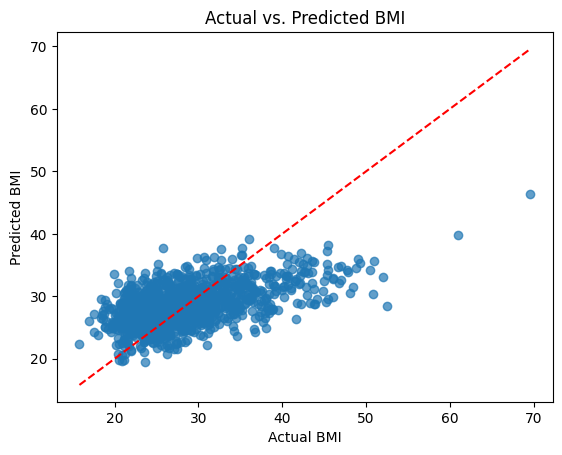

In [47]:
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Perfect prediction line
plt.xlabel('Actual BMI')
plt.ylabel('Predicted BMI')
plt.title('Actual vs. Predicted BMI')
plt.show()

### Gender Classification

#### Preparing feature set

Reducing feature set using PCA

In [41]:
reduced_features2,eigen_vecs2=pca(features,0.90)
print(reduced_features2.shape)

Mean vector shape: (3983,)
Covariance matrix shape: (3983, 3983)
(6000, 353)


Adding relevant columns

In [42]:
gender=person[['id','sex']]
ids=final_df['id'].to_numpy()
cols=['id']+[f'f{i}'for i in range(reduced_features2.shape[1])]
reduced_features2=np.column_stack((ids,reduced_features2))
class_df=pd.DataFrame(reduced_features2,columns=cols)
class_df=pd.merge(class_df,gender,on='id',how='inner')
class_df

id         f0         f1         f2         f3         f4  \
0     A01356  47.969916  13.420935  27.143861   7.393127  24.874397   
1     A01736  32.278264  10.568543   6.346597  17.686033  31.519147   
2     A02088  48.476324  14.860316  28.572998   4.107607   36.37748   
3     A10002  48.787277  16.620102   23.68114   1.692895  20.349978   
4     A10133  33.864569 -18.141395     9.9939  -9.519536  23.139848   
...      ...        ...        ...        ...        ...        ...   
5995  Y25331  21.693889 -27.145027   3.502521    1.99552  45.270585   
5996  Y25340  50.485785 -14.904181 -14.736202  12.040472  25.368334   
5997  Y25361  27.474966  19.301835  13.881627   8.593918  19.671165   
5998  Y25364  18.811351 -33.007394  22.207086   6.917194   17.74577   
5999  Y25365   0.786651 -19.085711  11.990147   -1.04473  14.969518   

             f5         f6         f7         f8  ...      f344      f345  \
0      5.031493   5.639154  15.783398  12.537023  ...  0.129935  0.244912   
1      3.875082  -1.936695  -0.347209  10.219424  ... -1.742654   1.71695   
2     -1.312677  -0.911238   7.755631   7.954945  ...  0.521448  1.242144   
3      1.484283  10.072408   7.228783    8.21279  ... -0.053203  0.039407   
4      8.704472   -5.67972   6.212414  -6.597863  ... -0.587796  0.565768   
...         ...        ...        ...        ...  ...       ...       ...   
5995    1.54988   11.65395   5.880838  14.756409  ...  0.397586  0.494131   
5996  -1.861515  -3.642233  12.899386  24.706873  ...  0.757249  0.376937   
5997    6.67047   -5.23412  21.000974  13.252463  ...  0.520831  0.881534   
5998  11.229002   2.589413   6.143276  15.171424  ...  0.214508   1.34963   
5999 -18.764357 -13.154278   3.345309  -0.263922  ...  1.342399  1.986566   

          f346      f347      f348      f349      f350      f351      f352  \
0    -1.576112 -1.101544   1.09624 -0.083682  0.999291  -1.58474 -3.025316   
1    -0.885115 -1.627984  2.627312 -0.225893  1.136449  0.723738 -0.815894   
2    -0.159654 -0.055034  0.152468 -0.396317  0.219848  0.725249 -2.196367   
3     -0.31313 -0.588041 -0.229561 -0.231951  0.550198  0.639723 -0.805035   
4    -0.130885 -0.841874    1.7253  0.060509  0.436311  0.819126  -0.90518   
...        ...       ...       ...       ...       ...       ...       ...   
5995 -0.432809 -0.831885 -0.125089 -0.963943 -0.040795 -0.055284 -0.942785   
5996  1.184846 -1.186555  1.320976 -1.113863  2.294485   0.08481 -1.419981   
5997  0.035853 -1.201046 -1.166097  0.222583  0.907945 -0.546983 -1.197499   
5998 -0.993425 -0.784069 -0.666008  0.086737  0.893879 -0.028579  0.371661   
5999 -0.429425  0.673878 -0.593743  0.452496 -0.823486  0.929977 -0.527336   

         sex  
0       Male  
1       Male  
2       Male  
3       Male  
4       Male  
...      ...  
5995  Female  
5996    Male  
5997    Male  
5998  Female  
5999  Female  

[6000 rows x 355 columns]

Gender distribution in sample

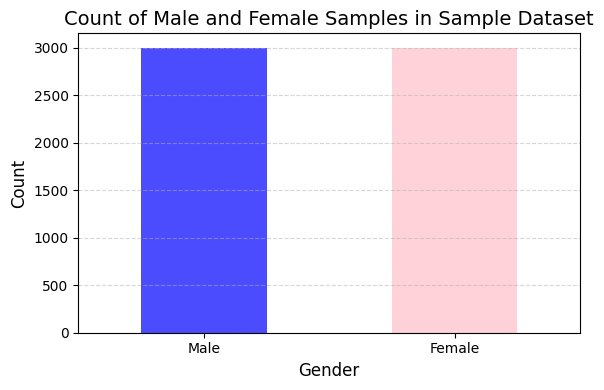

In [43]:
gender_counts = class_df['sex'].value_counts()

plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['blue', 'pink'], alpha=0.7)

# Adding labels and title
plt.title("Count of Male and Female Samples in Sample Dataset", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#### Splitting data into train and test

In [44]:
X_train2,X_test2,y_train2,y_test2=train_test_split(class_df.iloc[:,1:-1],class_df.iloc[:,-1],test_size=0.2,random_state=42)
print('Number of training samples:',len(X_train2))
print('Number of testing samples:',len(X_test2))

Number of training samples: 4800
Number of testing samples: 1200


#### Built-in SVM Model

In [45]:
X_train2=scaler.fit_transform(X_train2)
X_test2=scaler.transform(X_test2)

In [46]:
svm_model=SVC(kernel='rbf',C=1.0,gamma='scale',random_state=42)
svm_model.fit(X_train2,y_train2)

SVC(random_state=42)

In [47]:
y_pred2=svm_model.predict(X_test2)
accuracy2=accuracy_score(y_test2,y_pred2)
print(f"Accuracy:{accuracy2*100:.2f}%")

Accuracy:98.33%


#### SVM Model

In [48]:
def solve_alpha(x,y):

    #label multiplied to each sample
    X=y.reshape(-1,1)*x
    m=X.shape[0]

    #Hessian matrix , where each element is yi*yj(xi*xj)
    hessian=matrix(np.dot(X,X.T).astype('double'))

    #Represent negative of sum of lagrange multipliers.
    q=matrix(-np.ones((m,1)))

    #Helps enforce alphai>=0 
    G=matrix(-np.eye(m))
    h=matrix(np.zeros(m))

    #Ensures sigma(alphai*yi)=0
    A=matrix(y,(1,m),'d')
    b=matrix(0.0)

    #minimize 1/2*xT*P*x + qTx
    #subject to Gx<=h and Ax=b
    solution=solvers.qp(hessian,q,G,h,A,b)
    alphas=np.ravel(solution['x'])
    return alphas

def svm(x,y):
    alphas=solve_alpha(x,y)

    #support vectors have non-zero lagrange multipliers
    sv=alphas>1e-4
    sv_alpha=alphas[sv]
    sv_x=x[sv]
    sv_y=y[sv]

    #w=sigma(alphai*yi*xi)
    w=np.sum((sv_alpha*sv_y).reshape(-1,1)*sv_x,axis=0)
    
    #b=yi-(w.xi) and mean over all the support vectors.
    b=np.mean(sv_y-np.dot(sv_x,w))
    w.flatten()

    print("w: ", w)
    print(f"b: {b:.3f}")
    print("Support vectors: ", sv_x )
    print(f"\n Decision Boundary : {w[0]:.3f}x₁ + {w[1]:.3f}x₂ + {b:.3f} = 0")
    return w,b

def predict(x, w, b):
    return np.where(np.dot(x, w) + b > 0, 1, -1)

In [49]:
y_train2=y_train2.map({'Male':1,'Female':-1})
y_test2=y_test2.map({'Male':1,'Female':-1})
y_train2=np.array(y_train2)
w,b=svm(X_train2,y_train2)
y_pred2=predict(X_test2,w,b)
correct_predictions = np.sum(y_pred2 == y_test2)  
total_predictions = len(y_test2)  
accuracy = correct_predictions / total_predictions 
print(f'Accuracy of the SVM model: {accuracy * 100:.2f}%')

     pcost       dcost       gap    pres   dres
 0: -6.3303e+02 -1.8740e+03  3e+04  1e+02  3e+00
 1: -1.2741e+03 -2.1281e+03  2e+04  8e+01  2e+00
 2: -1.4794e+03 -1.0510e+03  1e+04  3e+01  7e-01
 3: -5.2137e+02 -1.0911e+02  2e+03  8e+00  2e-01
 4: -9.2393e+00 -2.4741e+01  7e+01  1e-01  3e-03
 5: -7.6102e+00 -1.4700e+01  9e+00  7e-03  1e-04
 6: -9.8521e+00 -1.3655e+01  4e+00  3e-03  6e-05
 7: -1.1435e+01 -1.3100e+01  2e+00  8e-04  2e-05
 8: -1.2290e+01 -1.2870e+01  6e-01  2e-04  4e-06
 9: -1.2632e+01 -1.2797e+01  2e-01  4e-05  9e-07
10: -1.2744e+01 -1.2775e+01  3e-02  5e-06  1e-07
11: -1.2769e+01 -1.2772e+01  3e-03  5e-07  1e-08
12: -1.2771e+01 -1.2771e+01  1e-04  1e-08  3e-10
13: -1.2771e+01 -1.2771e+01  4e-06  5e-10  1e-11
Optimal solution found.
w:  [ 3.31470476e+00  8.32471345e-01  1.12733678e+00 -5.50238499e-01
  1.81231583e-01 -1.23855352e+00 -9.90872179e-02  1.01308939e+00
 -4.85295545e-01 -2.30169749e-01  1.22711489e+00  1.58536730e-01
  2.44345310e-01  3.07610588e-01  7.6364805

### Testing on custom data

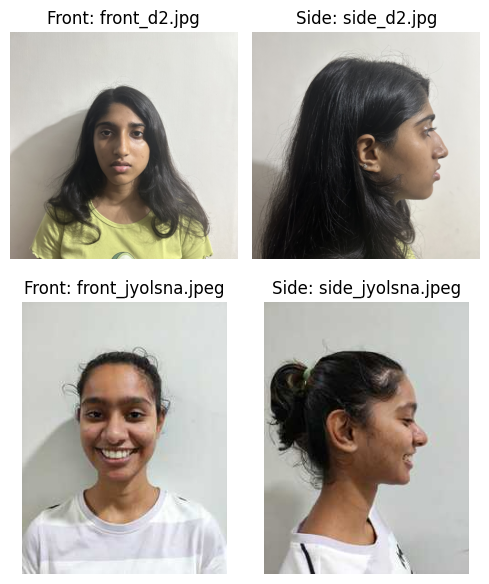

In [50]:
front_src='custom/front'
side_src='custom/side'
display_images(front_src,side_src,2)

#### Extracting features from images

Using mtcnn to detect face and then extract features using VGG16

Processing: custom/front\front_d2.jpg


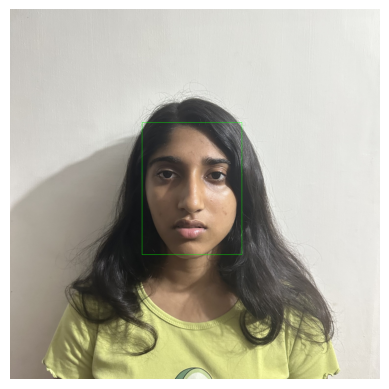

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Processing: custom/front\front_jyolsna.jpeg


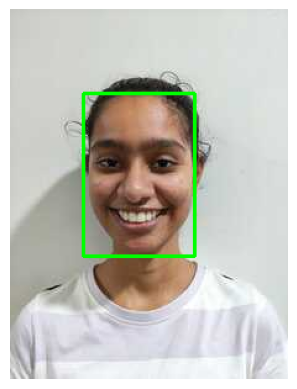

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Processing: custom/front\front_megha.jpeg


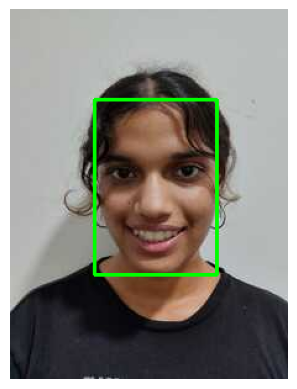

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Processing: custom/side\side_d2.jpg


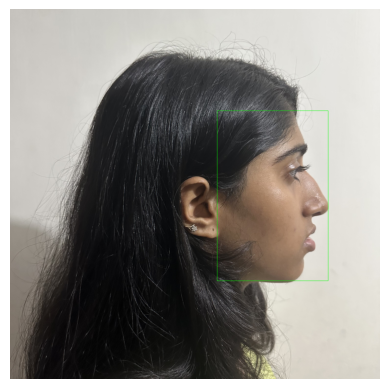

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Processing: custom/side\side_jyolsna.jpeg


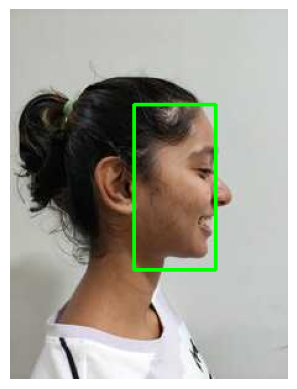

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Processing: custom/side\side_megha.jpeg


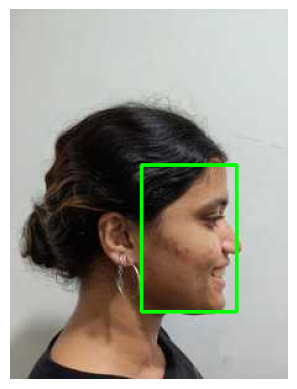

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
d2: (8192,)
jyolsna: (8192,)
megha: (8192,)


In [51]:

def extract_custom_features(src_folder):
    custom_features = {}
    for image in os.listdir(src_folder):
        if image.endswith(('.jpg', '.jpeg')):
            name = os.path.splitext(image)[0].replace('front_', '').replace('side_', '')
            img_path = os.path.join(src_folder, image)
            print(f"Processing: {img_path}")

            detected_face_display(cv2.imread(img_path))
            
            custom_features[name] = extract_features(img_path)
    return custom_features

front_features = extract_custom_features(front_src)
side_features = extract_custom_features(side_src)

# Combine features
final_features = {}
for name in front_features:
    if name in side_features:  # Ensure both front and side features are available
        combined_features = np.concatenate([front_features[name], side_features[name]])
        final_features[name] = combined_features

# Print feature shapes for verification
for name, f in final_features.items():
    print(f"{name}: {f.shape}")

Storing in dataframe and renaming columns

In [52]:
cols=[f"f{i}" for i in range(4096)]+[f"s{i}" for i in range(4096)]
new_df = pd.DataFrame.from_dict(final_features, orient='index', columns=cols)
new_df

f0   f1   f2   f3   f4   f5   f6   f7        f8   f9  ...     s4086  \
d2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.239170  0.0  ...  0.323446   
jyolsna  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.964544  0.0  ...  0.000000   
megha    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.805966  0.0  ...  0.000000   

            s4087  s4088  s4089     s4090     s4091  s4092     s4093  s4094  \
d2       0.250868    0.0    0.0  0.000000  4.704810    0.0  1.432511    0.0   
jyolsna  0.366661    0.0    0.0  0.880395  2.194154    0.0  0.713497    0.0   
megha    0.000000    0.0    0.0  0.000000  1.505167    0.0  2.021897    0.0   

            s4095  
d2       0.000000  
jyolsna  0.000000  
megha    0.665172  

[3 rows x 8192 columns]

Removing the same columns dropped before

In [53]:
new_df=new_df.drop(columns=cols_all_zero)
new_df

f0   f1   f2   f3   f4   f5   f6   f7        f8   f9  ...     s4086  \
d2       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.239170  0.0  ...  0.323446   
jyolsna  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  5.964544  0.0  ...  0.000000   
megha    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  4.805966  0.0  ...  0.000000   

            s4087  s4088  s4089     s4090     s4091  s4092     s4093  s4094  \
d2       0.250868    0.0    0.0  0.000000  4.704810    0.0  1.432511    0.0   
jyolsna  0.366661    0.0    0.0  0.880395  2.194154    0.0  0.713497    0.0   
megha    0.000000    0.0    0.0  0.000000  1.505167    0.0  2.021897    0.0   

            s4095  
d2       0.000000  
jyolsna  0.000000  
megha    0.665172  

[3 rows x 8073 columns]

In [54]:
new_df=new_df.drop(columns=cols_drop)
new_df

f8       f10       f13       f16       f19       f20       f21  \
d2       1.239170  0.000000  0.000000  1.162378  0.000000  1.120819  6.974770   
jyolsna  5.964544  5.275333  4.930537  0.000000  2.965263  3.205368  3.093085   
megha    4.805966  3.145802  2.044296  0.000000  4.274509  1.279342  3.784030   

         f24       f26       f30  ...     s4080     s4081     s4082     s4083  \
d2       0.0  0.000000  2.617565  ...  0.588027  5.138278  0.000000  3.587138   
jyolsna  0.0  2.259459  1.901299  ...  1.023197  1.909445  0.867704  1.153225   
megha    0.0  0.064949  2.495910  ...  0.327335  1.668913  0.853453  0.563597   

         s4085     s4090     s4091     s4093  s4094     s4095  
d2         0.0  0.000000  4.704810  1.432511    0.0  0.000000  
jyolsna    0.0  0.880395  2.194154  0.713497    0.0  0.000000  
megha      0.0  0.000000  1.505167  2.021897    0.0  0.665172  

[3 rows x 3983 columns]

In [55]:
new_features=new_df.to_numpy()
print(new_features.shape)

(3, 3983)


Reducing feature set using the corresponding eigen vectors for BMI

In [56]:
new_red_data=np.dot(new_features,eigen_vecs)
print(new_red_data.shape)

(3, 353)


Predicting BMI

In [57]:
new_test=scaler.fit_transform(new_red_data)
new_pred=reg_model.predict(new_test)
print(new_pred)

[26.31992001 30.94690598 29.04936636]


In [58]:
for name, pred in zip(final_features.keys(), new_pred):
    print(f"{name.capitalize()}: {pred}, {find_label(pred)}")

D2: 26.319920006759627, Overweight
Jyolsna: 30.94690597906668, Obese
Megha: 29.049366364549222, Overweight


Reducing feature set using the corresponding eigen vectors for Gender

In [59]:
new_test2=np.dot(new_features,eigen_vecs2)
print(new_test2.shape)

(3, 353)


Predicting gender using Built-in SVM

In [60]:
new_test2=scaler.fit_transform(new_test2)
new_ypred2=predict(new_test2,w,b)
print(new_ypred2)

[ 1  1 -1]


In [61]:
mapping={-1:'Female',1:'Male'}
mapped=np.vectorize(mapping.get)(new_ypred2)
for name, pred in zip(final_features.keys(), mapped):
    print(f"{name.capitalize()}: {pred}")

D2: Male
Jyolsna: Male
Megha: Female


SVM

In [62]:
new_pred2=svm_model.predict(new_test2)
print(new_pred2)

['Male' 'Male' 'Female']


### Plotting distribution of Offences

In [51]:
crimes=pd.read_csv(os.path.join(base_dir, 'csv','sentencing.csv'),sep=';')
crimes

id     mittimus class  count  \
0       A00147       82CF32     1      2   
1       A00147       82CF32     X      1   
2       A00147       82CF32     X      1   
3       A00147       82CF32     2      1   
4       A00220      7916505     3      1   
...        ...          ...   ...    ...   
245640  Y32582      17CF199     2      1   
245641  Y32582      17CF199     4      1   
245642  Y54605  15CR0531401     1      1   
245643  Y54605  15CR0215001     1      1   
245644  Y54605  15CR0215001     1      1   

                                     offense custody_date  \
0                  AGGR KIDNAPPING-NO RANSOM   11/26/1982   
1       ATTEMPT MURDER/INTENT TO KILL/INJURE   11/26/1982   
2                                       RAPE   11/26/1982   
3                                   BURGLARY   11/26/1982   
4                           ATTEMPT BURGLARY   00/00/0000   
...                                      ...          ...   
245640         AID/ABET/POSS/SELL STOLEN VEH   05/28/2018   
245641            AGG FLEEING/2+ CON DEVICES   05/28/2018   
245642        INVOL SEX SERV MINOR AGE 17-18   02/09/2015   
245643        INVOL SEX SERV MINOR AGE 17-18   02/09/2015   
245644        TRAFFICKING FOR LABOR/BENEFITS   02/09/2015   

                        sentence     county sentence_discharged  Unnamed: 9  
0       30 Years 0 Months 0 Days     JASPER                  NO         NaN  
1       50 Years 0 Months 0 Days     JASPER                  NO         NaN  
2       50 Years 0 Months 0 Days     JASPER                  NO         NaN  
3       14 Years 0 Months 0 Days     JASPER                  NO         NaN  
4        2 Years 0 Months 0 Days       COOK                 YES         NaN  
...                          ...        ...                 ...         ...  
245640   3 Years 0 Months 0 Days  MCDONOUGH                  NO         NaN  
245641   1 Years 0 Months 0 Days  MCDONOUGH                  NO         NaN  
245642   4 Years 6 Months 0 Days       COOK                  NO         NaN  
245643   4 Years 6 Months 0 Days       COOK                  NO         NaN  
245644   4 Years 6 Months 0 Days       COOK                  NO         NaN  

[245645 rows x 10 columns]

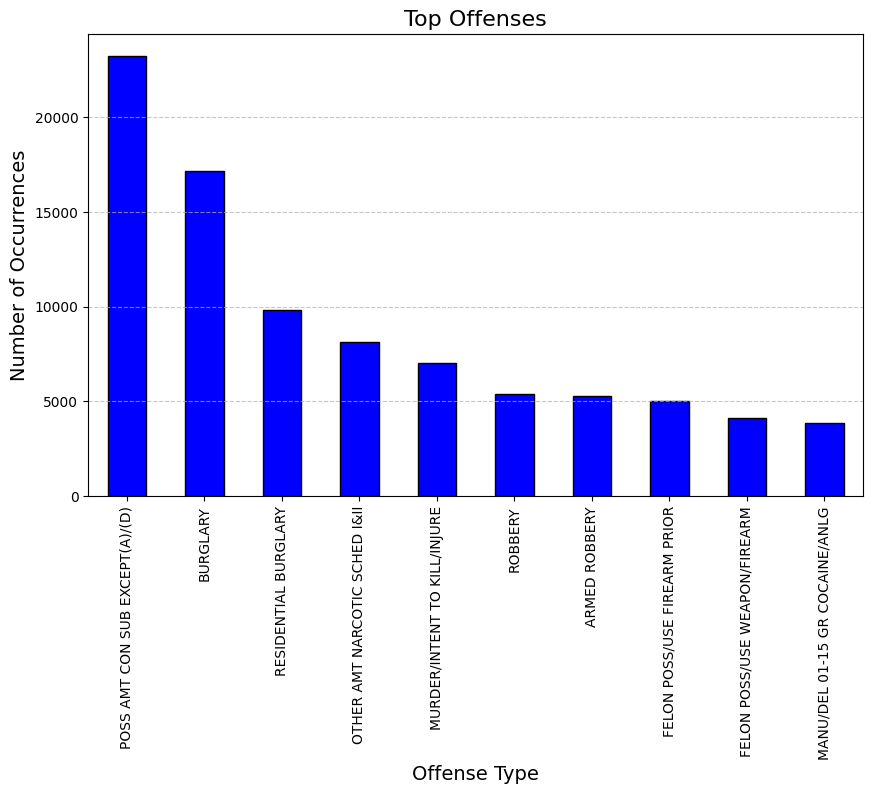

In [52]:
offences=crimes['offense'].value_counts()
top_offences=offences.head(10)
plt.figure(figsize=(10, 6))
top_offences.plot(kind='bar', color='blue', edgecolor='black')

plt.title('Top Offenses', fontsize=16)
plt.xlabel('Offense Type', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()